<a href="https://colab.research.google.com/github/Bibhash123/competition_quickstart_dataloader/blob/main/gbm-models-lgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
!pip install -U layer
clear_output(wait = False)

In [ ]:
import layer
from layer.decorators import dataset,model, pip_requirements, resources
layer.login()

In [ ]:
layer.init("rci-competition")

Your Layer project is here: https://app.layer.ai/bibhash/rci-competition

## Imports

In [1]:
import os
import gc
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import warnings
from lightgbm import LGBMRegressor

warnings.filterwarnings(action='ignore', category=UserWarning)

In [2]:
def rank_data(series):
    return (series.rank() - 1) / (len(series) - 1)

# **Data Preparation**

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!wget https://rocketcompetition.mypinata.cloud/ipfs/Qmc5eTuSvaz4Af1pAwTj69W4WmhXHDM4SS3YZKsEx4nv3G
!unzip -q Qmc5eTuSvaz4Af1pAwTj69W4WmhXHDM4SS3YZKsEx4nv3G -d "/content/"
!rm -r Qmc5eTuSvaz4Af1pAwTj69W4WmhXHDM4SS3YZKsEx4nv3G

--2022-08-10 15:54:02--  https://rocketcompetition.mypinata.cloud/ipfs/Qmc5eTuSvaz4Af1pAwTj69W4WmhXHDM4SS3YZKsEx4nv3G
Resolving rocketcompetition.mypinata.cloud (rocketcompetition.mypinata.cloud)... 104.18.30.237, 104.18.31.237, 2606:4700::6812:1eed, ...
Connecting to rocketcompetition.mypinata.cloud (rocketcompetition.mypinata.cloud)|104.18.30.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378472291 (361M) [application/zip]
Saving to: ‘Qmc5eTuSvaz4Af1pAwTj69W4WmhXHDM4SS3YZKsEx4nv3G’

Qmc5eTuSvaz4Af1pAwT 100%[===================>] 360.94M  16.1MB/s    in 29s     

2022-08-10 15:54:36 (12.6 MB/s) - ‘Qmc5eTuSvaz4Af1pAwTj69W4WmhXHDM4SS3YZKsEx4nv3G’ saved [378472291/378472291]



### Loading train_dataset and validation_dataset

In [5]:
train_dataset  = pd.read_csv('/content/dataset/train_dataset.csv', index_col = 'date')
validation_dataset  = pd.read_csv('/content/dataset/validation_dataset.csv', index_col = 'date')
print("Shape of train set:",train_dataset.shape)
print("Shape of test set:",validation_dataset.shape)

Shape of train set: (85378, 2013)
Shape of test set: (724, 2013)


In [6]:
train_dataset = train_dataset.sort_values(by=["symbol","date"]).reset_index(drop=False)
validation_dataset = validation_dataset.sort_values(by=["symbol","date"]).reset_index(drop=False)

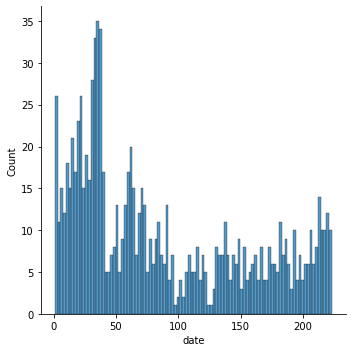

In [7]:
df = train_dataset.groupby("symbol")['date'].count().to_frame().reset_index()
sns.displot(df['date'],bins = 100)

In [8]:
# first column (symbol) is the ticker
# 'target_DC1' is the log of return for delta between current close to previous close
# 'target' is the y which is ranked by Era using 'target_DC1'
# the rest of the columns are features to be used for ML
train_dataset.head()

,date,symbol,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_2003,feature_2004,feature_2005,feature_2006,feature_2007,feature_2008,feature_2009,feature_DC1,target,target_DC1
0,2018-12-23,0xBTC,0.974026,0.987013,0.978355,0.991342,0.982684,0.982684,0.982684,0.978355,...,0.887446,0.857143,0.857143,0.857143,0.835498,0.839827,0.839827,0.891775,0.095238,-0.211551
1,2018-12-30,0xBTC,0.016878,0.033755,0.949367,0.936709,0.978903,0.907173,0.962025,0.953586,...,0.936709,0.953586,0.962025,0.932489,0.940928,0.945148,0.915612,0.101266,0.046414,-0.192849
2,2019-01-06,0xBTC,0.158996,0.016736,0.033473,0.928870,0.868201,0.941423,0.740586,0.933054,...,0.891213,0.874477,0.857741,0.912134,0.849372,0.807531,0.878661,0.050209,0.284519,-0.263822
3,2019-01-13,0xBTC,0.737500,0.279167,0.020833,0.054167,0.945833,0.908333,0.962500,0.870833,...,0.645833,0.600000,0.541667,0.691667,0.591667,0.504167,0.670833,0.287500,0.391667,0.023985
4,2019-01-20,0xBTC,0.983607,0.987705,0.983607,0.430328,0.971311,0.991803,0.987705,0.991803,...,0.504098,0.454918,0.422131,0.553279,0.368852,0.331967,0.450820,0.397541,0.032787,-0.251842


In [9]:
info = train_dataset.describe().transpose().reset_index()

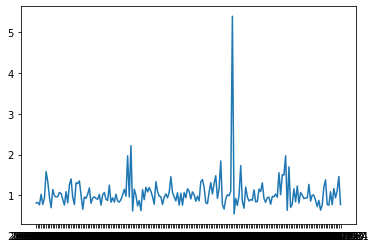

In [10]:
plt.plot(train_dataset[train_dataset['symbol']=='0xBTC']['date'], np.exp(train_dataset[train_dataset['symbol']=='0xBTC']['target_DC1']))

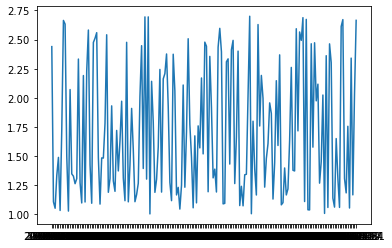

In [11]:
plt.plot(train_dataset[train_dataset['symbol']=='0xBTC']['date'], np.exp(train_dataset[train_dataset['symbol']=='0xBTC']['feature_DC1']))

In [12]:
symbols = train_dataset.symbol.unique()
trainsize = train_dataset.shape[0]

train_dataset = pd.concat([train_dataset, validation_dataset], axis = 0)
train_dataset['dc1_lag1'] = -1
train_dataset['dc1_lag1_rolling'] = -1
train_dataset['dc1_lag2'] = -1
train_dataset['target_lag1'] = -1
train_dataset['target_lag2'] = -1

for sym in tqdm(symbols):
  train_dataset.loc[train_dataset['symbol']==sym,'dc1_lag1'] = train_dataset[train_dataset['symbol']==sym]['target_DC1'].shift(1)
  train_dataset.loc[train_dataset['symbol']==sym,'target_lag1'] = train_dataset[train_dataset['symbol']==sym]['target'].shift(1)
  train_dataset.loc[train_dataset['symbol']==sym,'dc1_lag2'] = train_dataset[train_dataset['symbol']==sym]['target_DC1'].shift(2)
  train_dataset.loc[train_dataset['symbol']==sym,'target_lag2'] = train_dataset[train_dataset['symbol']==sym]['target'].shift(2)
  train_dataset.loc[train_dataset['symbol']==sym,'dc1_lag1_rolling'] = train_dataset.loc[train_dataset['symbol']==sym,'dc1_lag1'].rolling(window=3).sum()

train_dataset['dc1_lag1_exp'] = np.exp(train_dataset['dc1_lag1'])
train_dataset.fillna(-1,inplace = True)
train_dataset['month'] = pd.to_datetime(train_dataset['date']).apply(lambda x: x.month)
train_dataset['year'] = pd.to_datetime(train_dataset['date']).apply(lambda x: x.year)
train_dataset['day'] = pd.to_datetime(train_dataset['date']).apply(lambda x: x.day)



validation_dataset = train_dataset.iloc[trainsize:]
train_dataset = train_dataset.iloc[:trainsize]

  0%|          | 0/979 [00:00<?, ?it/s]

### Create X and y from train_dataset

### Each era representing a set of cryptocurrency assets for the time period, the number of assets within each Era is different

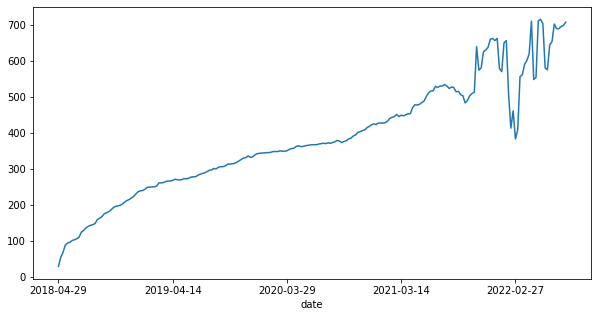

In [13]:
train_dataset.groupby(train_dataset.date).count().iloc[:,1].plot(figsize = (10,5));

### Split dataset into train and test by era

In [14]:
# Run Once
train = 0.9
test = 0.1
dates = sorted(train_dataset.date.unique())
era = len(dates)
train_era = int(era * train)
test_era = era - train_era
print('total Era: {}'.format(era))
print('train Era: {}'.format(train_era))
print('validation Era: {}'.format(test_era))

total Era: 223
train Era: 200
validation Era: 23


In [15]:
#split train and test set according to the train_era and test_era
# Run Once
train_set = train_dataset.loc[train_dataset.date < dates[train_era]]
val_set = train_dataset.loc[train_dataset.date >= dates[train_era]]
print('Train dataset shape: {}'.format(train_set.shape))
print('Validation dataset shape: {}'.format(val_set.shape))

Train dataset shape: (71064, 2023)
Validation dataset shape: (14314, 2023)


In [16]:
train_set.to_csv("train_set.csv",index = False)
val_set.to_csv("val_set.csv",index = False)
validation_dataset.to_csv("test_set.csv",index = False)

In [ ]:
os.kill(os.getpid(), 9)

In [4]:
train_set = pd.read_csv("train_set.csv")
val_set = pd.read_csv("val_set.csv")
validation_dataset= pd.read_csv("test_set.csv")

In [5]:
train_set.head()

,date,symbol,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,target_DC1,dc1_lag1,dc1_lag1_rolling,dc1_lag2,target_lag1,target_lag2,dc1_lag1_exp,month,year,day
0,2018-12-23,0xBTC,0.974026,0.987013,0.978355,0.991342,0.982684,0.982684,0.982684,0.978355,...,-0.211551,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,12,2018,23
1,2018-12-30,0xBTC,0.016878,0.033755,0.949367,0.936709,0.978903,0.907173,0.962025,0.953586,...,-0.192849,-0.211551,-1.000000,-1.000000,0.095238,-1.000000,0.809328,12,2018,30
2,2019-01-06,0xBTC,0.158996,0.016736,0.033473,0.928870,0.868201,0.941423,0.740586,0.933054,...,-0.263822,-0.192849,-1.000000,-0.211551,0.046414,0.095238,0.824607,1,2019,6
3,2019-01-13,0xBTC,0.737500,0.279167,0.020833,0.054167,0.945833,0.908333,0.962500,0.870833,...,0.023985,-0.263822,-0.668222,-0.192849,0.284519,0.046414,0.768110,1,2019,13
4,2019-01-20,0xBTC,0.983607,0.987705,0.983607,0.430328,0.971311,0.991803,0.987705,0.991803,...,-0.251842,0.023985,-0.432686,-0.263822,0.391667,0.284519,1.024275,1,2019,20


In [6]:
with_target = True

In [7]:
from xgboost import XGBRegressor

params = {'objective' : "reg:squarederror", 
          'n_estimators' : 1000, 
          'tree_method' : "gpu_hist", 
          'learning_rate': 0.03,                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
          'reg_alpha':0.1,
          'reg_lambda':0.01,
          'subsample': 0.8,
          'colsample_bytree':0.8,
          'colsample_bylevel':0.8,
          'max_depth':9, 
          "reg_alpha":0.01
}

def fitXGB(with_target = with_target):
  X_train = train_set.drop(['date','symbol','target','target_DC1'], axis = 1)
  X_val = val_set.drop(['date','symbol','target','target_DC1'], axis = 1)

  if with_target:
    Y_train = train_set['target']
    Y_val = val_set['target']
  else:
    Y_train = train_set['target_DC1']
    Y_val = val_set['target_DC1']
  
  reg = XGBRegressor(**params)
  reg.fit(X_train,Y_train, eval_metric = "rmse",
          eval_set=[(X_train,Y_train),(X_val,Y_val)], 
          early_stopping_rounds = 10)
  return reg

xgb = fitXGB()

[0]	validation_0-rmse:0.288556	validation_1-rmse:0.289022
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.287658	validation_1-rmse:0.288897
[2]	validation_0-rmse:0.286804	validation_1-rmse:0.288727
[3]	validation_0-rmse:0.28588	validation_1-rmse:0.288624
[4]	validation_0-rmse:0.285016	validation_1-rmse:0.288506
[5]	validation_0-rmse:0.284196	validation_1-rmse:0.288408
[6]	validation_0-rmse:0.283341	validation_1-rmse:0.28832
[7]	validation_0-rmse:0.282499	validation_1-rmse:0.288216
[8]	validation_0-rmse:0.281665	validation_1-rmse:0.288103
[9]	validation_0-rmse:0.28087	validation_1-rmse:0.288046
[10]	validation_0-rmse:0.280115	validation_1-rmse:0.287928
[11]	validation_0-rmse:0.279462	validation_1-rmse:0.28789
[12]	validation_0-rmse:0.278746	validation_1-rmse:0.287816
[13]	validation_0-rmse:0.27799	validation_1-rmse:0.287718
[14]	validation_0-rmse:0.27721

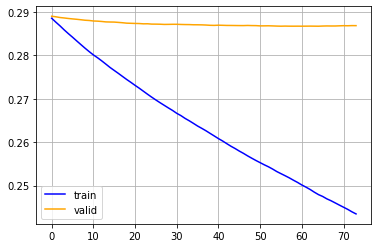

In [8]:
evals = xgb.evals_result()
evaluation_plot = plt.figure()
plt.grid()
plt.plot(evals['validation_0']['rmse'],c='blue',label = 'train')
plt.plot(evals['validation_1']['rmse'],c='orange',label = 'valid')
plt.legend()

In [9]:
import lightgbm as lgb

params = {'boosting_type': 'gbdt',
          'n_estimators':1000,
          'objective': 'regression',
          'learning_rate': 0.03,                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
          'reg_alpha':0.1,
          'reg_lambda':0.01,
          'max_depth':9,
          'subsample': 0.8,
          'colsample_bytree':0.8,
          'colsample_bylevel':0.8
          }
evals = {}

def fitLGB(with_target = with_target):
  X_train = train_set.drop(['date','symbol','target','target_DC1'], axis = 1)
  X_val = val_set.drop(['date','symbol','target','target_DC1'], axis = 1)
  cats = ['month','year','day']
  feature_name = X_train.columns.to_list()

  if with_target:
    Y_train = train_set['target']
    Y_val = val_set['target']
  else:
    Y_train = train_set['target_DC1']
    Y_val = val_set['target_DC1']
  
  reg = LGBMRegressor(**params)
  reg.fit(X_train,Y_train,
          eval_metric = "rmse",
          feature_name = feature_name ,
          categorical_feature = cats,
          early_stopping_rounds = 10,
          callbacks = [lgb.record_evaluation(evals)],
          eval_set=[(X_train,Y_train), (X_val,Y_val)],
          eval_names=['train','valid'])
  return reg

lgb = fitLGB()

[1]	train's rmse: 0.289214	train's l2: 0.0836445	valid's rmse: 0.289014	valid's l2: 0.0835291
Training until validation scores don't improve for 10 rounds.
[2]	train's rmse: 0.288934	train's l2: 0.083483	valid's rmse: 0.288912	valid's l2: 0.0834701
[3]	train's rmse: 0.288665	train's l2: 0.0833276	valid's rmse: 0.288835	valid's l2: 0.0834255
[4]	train's rmse: 0.288408	train's l2: 0.0831793	valid's rmse: 0.288741	valid's l2: 0.0833712
[5]	train's rmse: 0.288154	train's l2: 0.0830326	valid's rmse: 0.288658	valid's l2: 0.0833237
[6]	train's rmse: 0.287915	train's l2: 0.0828949	valid's rmse: 0.28856	valid's l2: 0.083267
[7]	train's rmse: 0.287691	train's l2: 0.0827664	valid's rmse: 0.288467	valid's l2: 0.083213
[8]	train's rmse: 0.287472	train's l2: 0.08264	valid's rmse: 0.288395	valid's l2: 0.0831719
[9]	train's rmse: 0.287251	train's l2: 0.082513	valid's rmse: 0.288332	valid's l2: 0.0831355
[10]	train's rmse: 0.287039	train's l2: 0.0823914	valid's rmse: 0.288262	valid's l2: 0.0830951
[11]

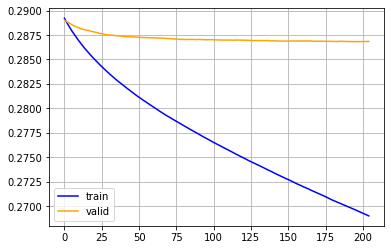

In [10]:
evaluation_plot = plt.figure()
plt.grid()
plt.plot(evals['train']['rmse'],c='blue',label = 'train')
plt.plot(evals['valid']['rmse'],c='orange',label = 'valid')
plt.legend()

In [11]:
def predictFunction(xgb, lgb, dataset, with_target = with_target):
  files = dataset.copy()
  xgb_pred = xgb.predict(files.drop(['date','symbol','target','target_DC1'], axis = 1))
  lgb_pred = lgb.predict(files.drop(['date','symbol','target','target_DC1'], axis = 1))

  if with_target:
    files.loc[:,'predicted_target'] = (xgb_pred.reshape((-1,1))+lgb_pred.reshape((-1,1)))/2
  else:
    files.loc[:,'predicted_DC1'] = (xgb_pred.reshape((-1,1))+lgb_pred.reshape((-1,1)))/2
    files.loc[:,'predicted_target'] = -1
    for date in files.date.unique():
      files.loc[files['date']==date,'predicted_target'] = rank_data(files[files['date']==date]['predicted_DC1'])
      
  return files[['symbol','date','predicted_target']]

In [12]:
# function to calculate Spearman correlation by era (mean, std, max, min)
# we want to maximize but maintain stable correlation across era to maximize both challenge and competition reward
def spearman_by_era(prediction,target, dates):
  df = pd.DataFrame(index=dates,
                    data = {'prediction': prediction,
                            'target': target}
                    )
  spearman_era_list = []
  for era in df.index.unique():
    era_df = df[df.index == era]
    spearman_corr = sp.stats.spearmanr(era_df.prediction, era_df.target)[0]
    spearman_era_list.append(spearman_corr)

  mean = np.mean(spearman_era_list)
  std = np.std(spearman_era_list)
  max = np.max(spearman_era_list)
  min = np.min(spearman_era_list)
  return mean, std, max, min
  

In [13]:
pred_train = predictFunction(xgb,lgb, train_set)
train_spearman = spearman_by_era(pred_train['predicted_target'].values, train_set['target'].values,
                                pred_train['date'].values)

print('Train dataset Spearman correlation: mean = {} ; std = {} ; max = {} ; min = {}'.format(round(train_spearman[0], 4), 
                                                                                            round(train_spearman[1], 4),
                                                                                            round(train_spearman[2], 4),
                                                                                            round(train_spearman[3], 4),
                                                                                            ))


Train dataset Spearman correlation: mean = 0.642 ; std = 0.0488 ; max = 0.7695 ; min = 0.5062


In [14]:
pred_val = predictFunction(xgb, lgb, val_set)
test_spearman = spearman_by_era(pred_val['predicted_target'].values, val_set['target'].values,
                                pred_val['date'].values)

print('Test dataset Spearman correlation: mean = {} ; std = {} ; max = {} ; min = {}'.format(round(test_spearman[0], 4),
                                                                                            round(test_spearman[1], 4),
                                                                                            round(test_spearman[2], 4),
                                                                                            round(test_spearman[3], 4),
                                                                                            ))

Test dataset Spearman correlation: mean = 0.1154 ; std = 0.0734 ; max = 0.2778 ; min = 0.0017


In [ ]:
mse = mean_squared_error(pred_val['predicted_target'],val_set['target'])
mae = mean_absolute_error(pred_val['predicted_target'],val_set['target'])
rmse = mean_squared_error(pred_val['predicted_target'],val_set['target'], squared = False)

In [ ]:
error = train_set[['symbol','date','target','target_DC1']].copy()
error['predicted'] = predictFunction(xgb, lgb, train_set)['predicted_target']
error['error'] = (error['target']-error['predicted'])**2
error

,symbol,date,target,target_DC1,predicted,error
0,0xBTC,2018-12-23,0.095238,-0.211551,0.456898,0.130798
1,0xBTC,2018-12-30,0.046414,-0.192849,0.472241,0.181329
2,0xBTC,2019-01-06,0.284519,-0.263822,0.468668,0.033911
3,0xBTC,2019-01-13,0.391667,0.023985,0.500698,0.011888
4,0xBTC,2019-01-20,0.032787,-0.251842,0.509609,0.227360
...,...,...,...,...,...,...
70183,ZYN,2021-12-26,0.727134,0.001455,0.490734,0.055885
70184,ZYN,2022-01-02,0.984894,0.447752,0.526780,0.209869
70185,ZYN,2022-01-23,0.884615,0.143837,0.480401,0.163389
70186,ZYN,2022-01-30,0.983232,0.591620,0.496266,0.237136


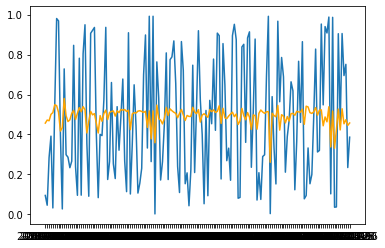

In [ ]:
plt.plot(error[error['symbol']=='0xBTC'].date, error[error['symbol']=='0xBTC'].target)
plt.plot(error[error['symbol']=='0xBTC'].date, error[error['symbol']=='0xBTC'].predicted, color='orange')

In [ ]:
error[error['error']==np.max(error['error'])]

,symbol,date,target,target_DC1,predicted,error
3676,ARN,2021-08-22,0.003802,-1.09234,0.591908,0.345868


In [ ]:
error[error['error']==np.min(error['error'])]

,symbol,date,target,target_DC1,predicted,error
69310,ZB,2019-12-01,0.5,0.002244,0.499999,1.642762e-12


In [ ]:
error[["target","target_DC1","error"]].corr()

,target,target_DC1,error
target,1.000000,0.672984,0.046621
target_DC1,0.672984,1.000000,0.120293
error,0.046621,0.120293,1.000000


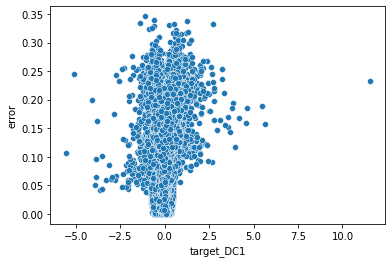

In [ ]:
error_plot = plt.figure()
sns.scatterplot(x = "target_DC1", y = "error", data = error)

Output()

[INFO] Number of important features: 773

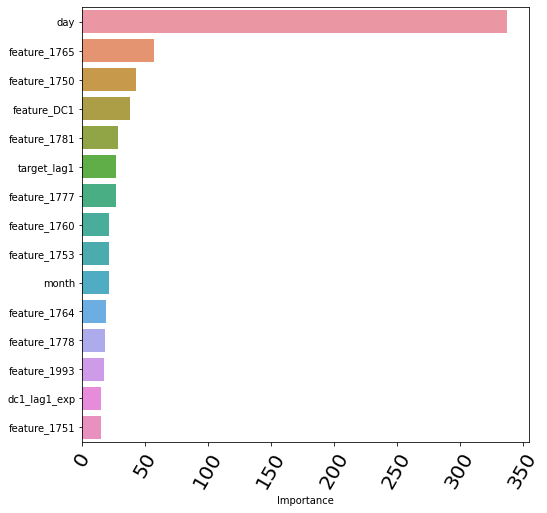

In [ ]:
@model("lgb_model")
def train_function():  
    importance = lgb.feature_importances_
    importances_rfc_df = pd.DataFrame(importance, index=train_set.drop(['date','symbol','target','target_DC1'], axis = 1).columns, columns=['Importance'])
    importances_rfc_df = importances_rfc_df.sort_values(by='Importance', ascending=False)
    importances_rfc_df = importances_rfc_df[importances_rfc_df['Importance'] > 0]
    print("[INFO] Number of important features:",importances_rfc_df.shape[0])
    importances_rfc_df = importances_rfc_df.head(15)

    plt.figure(figsize=(8,8))
    plt.xticks(rotation=60, fontsize = 20)
    sns.barplot(y=importances_rfc_df.index, x=importances_rfc_df['Importance'])
    
    
    layer.log(params)
    layer.log({'With Target':with_target})
    layer.log({'Mean Absolute Error':mae})
    layer.log({'Mean Squarred Error': mse})
    layer.log({'Root Mean Squared Error': rmse})
    layer.log({"Train mean pearson":round(train_spearman[0], 4)})
    layer.log({"Train std pearson":round(train_spearman[1], 4)})
    layer.log({"Validation mean pearson":round(test_spearman[0], 4)})
    layer.log({"Validation std pearson":round(test_spearman[1], 4)})
    layer.log({"Feature importance": plt.gcf()})
    layer.log({"Training metrics": evaluation_plot})
    layer.log({"Error Plot":error_plot})
    plt.show()
    return lgb

_ = train_function()

In [ ]:
pred_submission = predictFunction(xgb, lgb, validation_dataset)
pred_submission

,symbol,date,predicted_target
0,0xBTC,2022-07-24,0.500108
1,1ECO,2022-07-24,0.481130
2,1INCH,2022-07-24,0.534637
3,1WO,2022-07-24,0.474368
4,AAB,2022-07-24,0.519762
...,...,...,...
708,ZORA,2022-07-24,0.478308
709,ZRX,2022-07-24,0.534138
710,ZSC,2022-07-24,0.422418
711,ZYN,2022-07-24,0.537175


In [ ]:
# Use the trained Linear Regression model to make prediction on latest data
# X_validation = validation_dataset.iloc[:, 1:-2]
# y_validation_linear_reg = reg.predict(X_validation)
y_validation_linear_reg = pred_submission['predicted_target'].values
y_validation_linear_reg[:5]

array([0.50010775, 0.48112997, 0.53463727, 0.47436773, 0.51976175])

### Let's use the prediction from linear regression to join with validation dataset symbol for submission

In [ ]:
prediction = pd.DataFrame()
prediction['symbol'] = list(pred_submission.symbol)
prediction['prediction'] = y_validation_linear_reg

# sort the prediction to check which symbol is weaker and stronger, ie. FOX is weakest; BTC is strongest
prediction.sort_values('prediction')

,symbol,prediction
176,DMT,0.321689
215,EVED,0.325862
73,BOB,0.339576
613,TOP,0.340101
478,PPT,0.346978
...,...,...
343,LEVL,0.581946
77,BOR,0.596818
707,ZLW,0.600594
334,L2,0.625717


### Check is prediction dataframe in accordance for submission format (using the prediction from linear regression)

In [ ]:
#check if y_latest is in accordance to shape for submission
if set(prediction.symbol) == set(validation_dataset.symbol):
    print('symbol matched!')
else:
    print('symbol unmatched, the symbol in prediction df must match the symbol in validation_dataset...')
    
if prediction.shape[1] == 2:
    print('column counts ok!')
else:
    print('It should have 2 columns, first column with symbol, second with prediction...')


symbol matched!
column counts ok!


### Output prediction as a .csv file for submission!

In [ ]:
#Output submission as .csv file
#The prediction.csv is stored in content/prediction folder
import os
if not os.path.exists('/content/prediction'):
    os.makedirs('/content/prediction')
prediction.to_csv('/content/prediction/prediction.csv', index = False, header = None)

# **Submission Section**

## **Setup**

In [ ]:
!git clone https://github.com/rocketcapital-ai/competition_submission.git
%cd /content/competition_submission

Cloning into 'competition_submission'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 23 (delta 3), reused 19 (delta 3), pack-reused 0
Unpacking objects: 100% (23/23), done.
/content/competition_submission


In [ ]:
!pip install base58
!pip install PyYAML
!pip install requests
!pip install web3==5.29.2
!pip install pandas 
from IPython.display import clear_output
clear_output(wait = False)

In [ ]:
from lib.submitter import *

jwt = 'eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJ1c2VySW5mb3JtYXRpb24iOnsiaWQiOiIxMDIwZDY0OC1kNzQ5LTQ5YjItOTZmZS1hNWQ0NDY5ODRjNTQiLCJlbWFpbCI6ImJpYmhhc2hwLmRhc0BnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwicGluX3BvbGljeSI6eyJyZWdpb25zIjpbeyJpZCI6IkZSQTEiLCJkZXNpcmVkUmVwbGljYXRpb25Db3VudCI6MX0seyJpZCI6Ik5ZQzEiLCJkZXNpcmVkUmVwbGljYXRpb25Db3VudCI6MX1dLCJ2ZXJzaW9uIjoxfSwibWZhX2VuYWJsZWQiOmZhbHNlLCJzdGF0dXMiOiJBQ1RJVkUifSwiYXV0aGVudGljYXRpb25UeXBlIjoic2NvcGVkS2V5Iiwic2NvcGVkS2V5S2V5IjoiYmM4NWI0ZDQ1N2FhYWZlNzBmNGIiLCJzY29wZWRLZXlTZWNyZXQiOiJlMmEyOGFlZmFlNTcyMWZkNzM1Mjg4NzE5OTIzYTBkZTQ4MWY5NzUxZWQyZmVhMTE0MGJmYzRlNzNjNzRhYzI2IiwiaWF0IjoxNjU1MTM2Nzc4fQ.xl2FxgrL04kQIa7cIn89a_iE0I9xphiNf6K5K2mor5o'      # User-specified field.
address = '0xcF16365d53ed53055f39010830e3CcD5A7a8245E'  # User-specified field.
pk = '32316dfe607ed4a240ac29a6dcad9db6f484f0fbdf7894c15511237e1e13db70'       # User-specified field.
submitter = Submitter(jwt, address, pk)

## View wallet address information.

In [ ]:
print('MATIC balance for {}: {}'.format(submitter.address, submitter.get_matic_balance()))
print('MUSA balance for {}: {}'.format(submitter.address, submitter.get_musa_balance()))
print('Current stake for {}: {}'.format(submitter.address, submitter.get_stake()))

MATIC balance for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 0.985348923177361965
MUSA balance for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 0.869313545300001154
Current stake for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 249.381633229200001085


## **Retrieve Dataset and run models.**
### Please follow the instructions and example found [here](https://github.com/rocketcapital-ai/competition_quickstart_dataloader).

### When completed, please place final prediction csv file in the `file_to_submit` folder.

In [ ]:
!cp "/content/prediction/prediction.csv" "/content/competition_submission/file_to_submit/"

## **Set stake.** (optional)
### Skip if no changes need to be made.

In [ ]:
# set_stake_amount = 125.00  # User-specified field.
# transaction_success = submitter.set_stake(set_stake_amount)
# assert transaction_success, 'Setting stake failed.'

Setting gas price to 65 gwei.
Sending transaction 0xe3cf8d0d27ab1452e097706b3ceb1c3bb6f4ab91c181af5e21588934c3d82469
Transaction sent. Tx ID: 0xe3cf8d0d27ab1452e097706b3ceb1c3bb6f4ab91c181af5e21588934c3d82469


## **Submit predictions.**
Note that the same `submit_prediction` method should be used for re-submitting predictions.

In [ ]:
submission_file_name = 'prediction.csv'  # User-specified field.
transaction_success = submitter.submit_prediction(submission_file_name)
assert transaction_success, 'Submission failed.'

Encrypting file.
Zipping encrypted file.
Uploading and recording on blockchain.
Setting gas price to 58 gwei.
Sending transaction 0x3967e833545ef96b64960f5999f328ed4b22e233460c689f38c23bc72730db29
Transaction sent. Tx ID: 0x3967e833545ef96b64960f5999f328ed4b22e233460c689f38c23bc72730db29


### **Retrieve and double-check predictions.** (optional)
This section retrieves your submitted files, decrypts them, and compares them to the original file in `file_to_submit`.

If the verification fails, please wait a few minutes and perform the verification again. If the problem persists, please re-submit your predictions.

In [ ]:
verification_success = submitter.download_and_check(submission_file_name)
assert verification_success, 'Submission verification failed.'
print('Files are identical. Verification check passed.')

Retrieving file.
File retrieved.
File unzipped.
File decrypted. Comparing files.
Removing temp files.
Temp files removed.
Files are identical. Verification check passed.
